<a href="https://colab.research.google.com/github/Rehan-Syed/Rehan-Syed/blob/main/webappBlastDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#to prevent gpu to collapse it allow using at 50% of total gpu
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [34]:
# importing usefull transfer learning libraries

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import keras.backend as K
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
#to check our ploting area for images
x = np.array([0, 6])
y = np.array([0, 250])
plt.plot(x, y)
plt.show()

In [3]:
#changing image size for preprocessing purpose(as inception input size is 299)
image_size = [224, 224]
train_folder = '/content/drive/MyDrive/Actual-Dataset/Train'
test_folder = '/content/drive/MyDrive/Actual-Dataset/Test'
Class =['Healthy', 'LeafBlast']


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Importing the inceptionv3 library as shown below and adding the preprocessing layer to the front of inception v3 model from keras
# Here we will be using imagenet weights
resnet = ResNet50(input_shape= image_size + [3], weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 0s 0us/step


In [6]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [7]:
# adding input and output layers
x = Flatten()(resnet.output)

In [8]:
#initializing the inner layers by using sigmoid function
prediction = Dense(2, activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
resnet50 = ResNet50(weights='imagenet', include_top=False)
imege = '/content/drive/MyDrive/Actual-Dataset2/Train/LeafBlast_Disease/BLAST2_132.JPG'
img = image.load_img(imege, target_size = (224,224))
x=image.img_to_array(img)
x= np.expand_dims(x, axis=0)
x=preprocess_input(x)

features = resnet50.predict(x)
print(features.shape)
print(features)

In [9]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
#### Now plot filter outputs    
#Define a new truncated model to only include the conv layers of interest
#conv_layer_index = [1, 3, 6, 8, 11, 13, 15]
conv_layer_index = [1, 3]  #TO define a shorter model
outputs = [model.layers[i].output for i in conv_layer_index]
model_short = Model(inputs=model.inputs, outputs=outputs)
print(model_short.summary())

#Input shape to the model is 224 x 224. SO resize input image to this shape.
from keras.preprocessing.image import load_img, img_to_array
img = load_img('/content/drive/MyDrive/Actual-Dataset/Train/LeafBlast_Disease/LeafBlast Disease_Initial  (102).jpg', target_size=(224, 224)) #resnet50 user 224 as input

# convert the image to an array
img = img_to_array(img)
# expand dimensions to match the shape of model input
img = np.expand_dims(img, axis=0)

# Generate feature output by predicting on the input image
feature_output = model_short.predict(img)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)       0         
                                                                 
 conv1_conv (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 64)     256       
 n)                                                              
                                                                 
Total params: 9,728
Trainable params: 0
Non-trainable params: 9,728
_________________________________________________________________
None


In [ ]:
columns = 8
rows = 8
for ftr in feature_output:
    #pos = 1
    fig=plt.figure(figsize=(12, 12))
    for i in range(1, columns*rows +1):
        fig =plt.subplot(rows, columns, i)
        fig.set_xticks([])  #Turn off axis
        fig.set_yticks([])
        plt.imshow(ftr[0, :, :, i-1], cmap='gray')
        #pos += 1
    plt.show()

In [ ]:
#Calculating the evaluation matrix
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
!pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [31]:
# using this to tackle with loss cost and optimizer input weights by comparing the prediction and the loss function
model.compile(
#to check losses in categorical way
loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy']
)

DAta Augmentation

In [10]:
#by using the image generator for importing images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dg = ImageDataGenerator(preprocess_input
                              #validation_split=0.33,
                              #shear_range =0.3,
                              #zoom_range = 0.2,
                              #vertical_flip = True,
                              #fill_mode= 'nearest'
                              
                              )
test_dg = ImageDataGenerator(preprocess_input)


In [36]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_folder,
  validation_split=0.2,
  subset="training",
  seed=123,
  batch_size= 32,
  image_size=(224, 224)
)

Found 1060 files belonging to 2 classes.
Using 848 files for training.


In [38]:
class_names = train_ds.class_names
print(class_names)

['Healthy_Leaves', 'LeafBlast_Disease']


In [ ]:
# giving the training path to fatch images with classes by targeting its actual sizes
train_cell = train_dg.flow_from_directory('/content/drive/MyDrive/Actual-Dataset2/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical'
                                                 #subset='training'
                                          )


In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_folder,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224,224),
  batch_size=32)

Found 510 files belonging to 2 classes.
Using 102 files for validation.


In [29]:
# giving the testing path to fatch images with classes by targeting its actual sizes
test_cell = test_dg.flow_from_directory('/content/drive/MyDrive/Actual-Dataset2/validation',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical'
                                                 #subset='validation'
                                        )

Found 1195 images belonging to 2 classes.


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint=ModelCheckpoint('/content/drive/MyDrive/Actual-Dataset2/newresnet.h5',
                          monitor='val_accuracy',
                          mode='auto',
                          save_best_only=True,
                          verbose=1
                           )
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=50,
                       verbose=1,
                       restore_best_weights=True
                      )

callbacks=[checkpoint,earlystop]

In [32]:
#training my model wtih dense last layer and flatting the first layer
history = model.fit(
  train_cell,
  validation_data=test_cell,
  epochs=10,
  callbacks= callbacks,
  steps_per_epoch=len(train_cell),
  validation_steps=len(test_cell)
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
55/55 [==============================] - ETA: 0s - loss: 5.2132 - accuracy: 0.8218
Epoch 1: val_accuracy improved from -inf to 0.88117, saving model to /content/drive/MyDrive/Actual-Dataset2/newresnet.h5
55/55 [==============================] - 18s 255ms/step - loss: 5.2132 - accuracy: 0.8218 - val_loss: 2.3990 - val_accuracy: 0.8812
Epoch 2/10
55/55 [==============================] - ETA: 0s - loss: 0.9088 - accuracy: 0.9364
Epoch 2: val_accuracy did not improve from 0.88117
55/55 [==============================] - 12s 226ms/step - loss: 0.9088 - accuracy: 0.9364 - val_loss: 2.5814 - val_accuracy: 0.8795
Epoch 3/10
55/55 [==============================] - ETA: 0s - loss: 0.4401 - accuracy: 0.9524
Epoch 3: val_accuracy improved from 0.88117 to 0.89038, saving model to /content/drive/MyDrive/Actual-Dataset2/newresnet.h5
55/55 [==============================] - 13s 245ms/step - loss: 0.4401 - accuracy: 0.9524 - val_loss: 2.3318 - val_accuracy: 0.8904
Epoch 4/10
55/55 [========

Webapp development

In [19]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.1 MB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 55.8 MB/s 
     |████████████████████████████████| 212 kB 62.7 MB/s 
     |████████████████████████████████| 2.3 MB 48.3 MB/s 
     |████████████████████████████████| 272 kB 70.1 MB/s 
     |████████████████████████████████| 140 kB 65.0 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 57 kB 5.5 MB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 
     |████████████████████████████████| 271 kB 75.3 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 144 kB 50.0 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 80 kB 11.2 MB/s 
     |████████████████████████████████| 68 kB

In [33]:
#Loading Model
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Actual-Dataset2/newresnet.h5')

In [39]:
class_names = train_ds.class_names
print(class_names)

['Healthy_Leaves', 'LeafBlast_Disease']


In [40]:
def predict_image(img):
  img_4d=img.reshape(-1,224,224,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(2)}

In [41]:
import gradio as gr

In [42]:
image = gr.inputs.Image(shape=(224,224))
label = gr.outputs.Label(num_top_classes=2)

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://53121.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gradio/routes.py", line 256, in run_predict
    fn_index, raw_input, username, session_state
  File "/usr/local/lib/python3.7/dist-packages/gradio/blocks.py", line 546, in process_api
    predictions, duration = await self.call_function(fn_index, processed_input)
  File "/usr/local/lib/python3.7/dist-packages/gradio/blocks.py", line 462, in call_function
    block_fn.fn, *processed_input, limiter=self.limiter
  File "/usr/local/lib/python3.7/dist-packages/anyio/to_thread.py", line 32, in run_sync
    func, *args, cancellable=cancellable, limiter=limiter
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "/usr/local/lib/python3.7/dist-packages/gradio/interface.py", line 515, in <lam

Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7fb60c64b890>,
 'http://127.0.0.1:7860/',
 'https://53121.gradio.app')

In [ ]:
@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/drive/MyDrive/Dataset/model.h5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Rice leaf blast disease detection
         """
         )
0
file = st.file_uploader("Please upload an Image")
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):
      size = (224,224)    
      image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
      image = np.asarray(image)
      img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
        
      img_reshape = img[np.newaxis,...]
    
      prediction = model.predict(img_reshape)
        
return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(prediction)
    st.write(score)
    print(
    "This is leaf blast disease with resistance saverity {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
check_acc = model.evaluate_generator(train_cell)[1]
print('The training accuracy is =', check_acc)

Confusion matrix


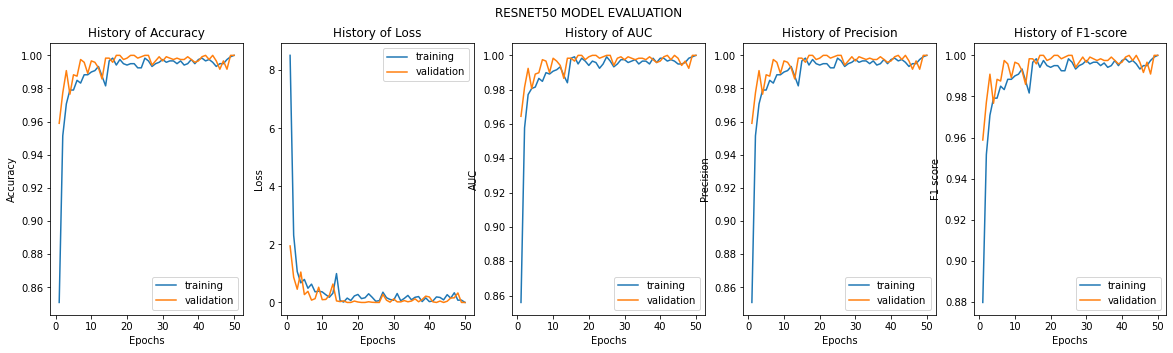

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle("RESNET50 MODEL EVALUATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print("evaluating network...")
##test_set.reset()
predIdxs = model.predict(x=test_cell)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(test_cell.classes, predIdxs,
	target_names=test_cell.class_indices.keys()))

evaluating network...


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


                   precision    recall  f1-score   support

   Healthy_Leaves       0.30      0.16      0.21       525
LeafBlast_Disease       0.70      0.84      0.76      1220

         accuracy                           0.63      1745
        macro avg       0.50      0.50      0.49      1745
     weighted avg       0.58      0.63      0.60      1745



/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


<Figure size 432x288 with 0 Axes>

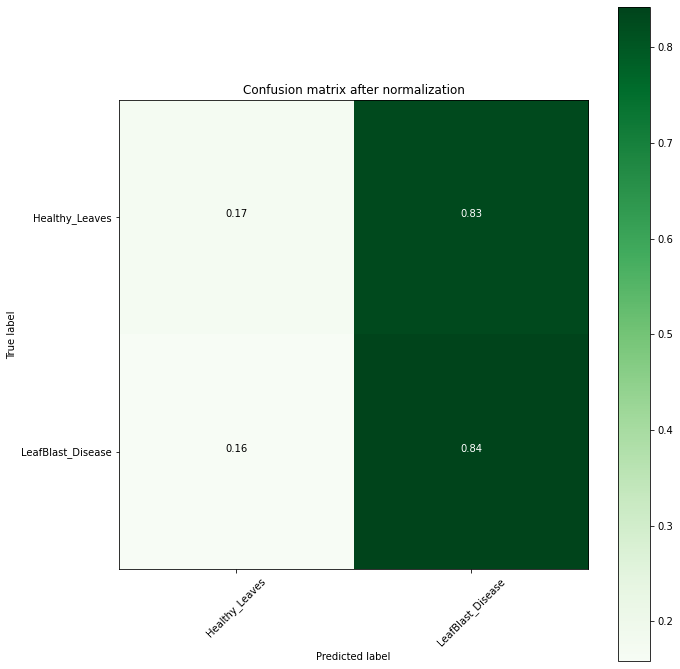

In [ ]:
# compute predictions
predictions = model.predict(test_cell)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_cell.classes
class_names = test_cell.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Greens):
    cm = cm.astype('int32') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=4)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix after normalization')
plt.show()

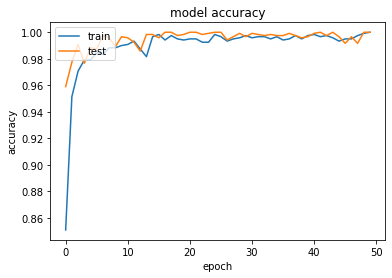

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plot to show
plt.show()

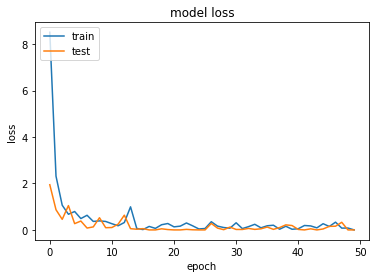

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Webapp development 

In [ ]:
!pip install jupyter-dash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 50.4 MB/s 
     |████████████████████████████████| 357 kB 68.5 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=91fe8e8430644d8ff9e28e39953131b67113720e5e88162c3f78ba3b273aae18
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output# Load Data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  after removing the cwd from sys.path.


In [ ]:
df = px.data.tips()# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("Rice Leaf blast disease detection"),
    dcc.Graph(id='graph'),
    html.Label([
        "colorscale",
        dcc.Dropdown(
            id='colorscale-dropdown', clearable=False,
            value='plasma', options=[
                {'label': c, 'value': c}
                for c in px.colors.named_colorscales()
            ])
    ]),
])# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("colorscale-dropdown", "value")]
)
def update_figure(colorscale):
    return px.scatter(
        df, x="total_bill", y="tip", color="size",
        color_continuous_scale=colorscale,
        render_mode="webgl", title="Tips"
    )# Run app and display result inline in the notebook

In [ ]:
app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>

In [ ]:
! pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 745 kB 34.5 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=22ea509702b826ac1b596ca821fcc5f7472d4af0c4edc5df62ed4fbd9657ecf6
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


In [ ]:
! ngrok authtoken 2AATiQJLqQ0uo6g4iEUCLbpsNK6_4v4hBdkSmrVDyZK6oAQ27

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Open a HTTP tunnel on the default port 80
public_url = ngrok.connect(port = '8050')

In [ ]:
public_url

<NgrokTunnel: "http://1842-34-143-185-45.ngrok.io" -> "http://localhost:80">

In [ ]:
ngrok.kill()